In [8]:
import pandas as pd
import numpy as np
import re
path = r'matala2_cosmetics_2019-Nov.csv'

In [9]:
data = pd.read_csv(path,low_memory=False)
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02,view,5802432,1487580009286590000,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09,cart,5844397,1487580006317030000,NaN,NaN,2.38 sale,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10,view,5837166,1783999064103190000,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11,cart,5876812,1487580010100290000,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24,remove_from_cart,5826182,1487580007483040000,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb


## 1. duration_to_next_event 

to manipulate our event_time we need that the dtype of that column will be **datetime**, lets check the dtype

In [10]:
data.dtypes

event_time       object
event_type       object
product_id        int64
category_id       int64
category_code    object
brand            object
price            object
user_id           int64
user_session     object
dtype: object

We can see that event_time standing on **object** dtype, lets convert it **&** sort the data by user_session.

In [11]:
data['event_time']= pd.to_datetime(data['event_time'])
data.dtypes

event_time       datetime64[ns]
event_type               object
product_id                int64
category_id               int64
category_code            object
brand                    object
price                    object
user_id                   int64
user_session             object
dtype: object

In [12]:
data = data.sort_values(by=['user_session','event_time'],ascending = True)

Now, lets use diff() to calculate time between events (We can see that the data already sorted so no action needed)

In [13]:
data['duration_to_next_event'] = (data['event_time'].shift(-1)-data['event_time']).dt.seconds
data.loc[data['user_session'].shift(-1) != data['user_session'], 'duration_to_next_event'] = None
data['duration_to_next_event'] = data['duration_to_next_event'].fillna(0)
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event
522763,2019-11-05 07:57:05,view,5829298,1487580011585070000,NaN,farmstay,0.79,556321594,00000dd2-0f5d-4fc9-9d6b-2fc8c7514b04,0.0
284392,2019-11-03 12:45:44,view,5846437,1487580013950660000,NaN,browxenna,45.24,473600495,00005ac0-5c22-4756-bb12-31b90af75fa3,11.0
284416,2019-11-03 12:45:55,view,5846436,1487580013950660000,NaN,browxenna,45.24,473600495,00005ac0-5c22-4756-bb12-31b90af75fa3,0.0
144335,2019-11-02 09:13:51,view,5887753,1487580013279570000,NaN,NaN,3.56,557616099,0000d358-49a1-4a54-b402-08205c35981c,0.0
853411,2019-11-07 11:18:15,view,59996,1487580012927250000,NaN,NaN,4.13,463202709,0000d72e-be5f-4a03-9f17-6ac81584f177,71.0


## 2. funnel_number

We can see our data sorted according to event_time column, In order to calculate the sessions we will need to make a Temporary data frame  
that sorted by user_id, In addition we will add the sessions value to a dict and than we will map them by user_id.  
**In addition, We will need to change event_time and drop the hours & seconds to calculate days difference for the fuunel column**

In [14]:
data_sorted = data.sort_values(by=['user_id','event_time'])
data_sorted['event_date'] = data_sorted['event_time'].dt.date

Now, lets create days_between column, we will use it to calculate the days gap for the sessions.  
**important! we have to make a condition between different users to ensure we will not mistakely calulate the days between them**

In [15]:
data_sorted['days_between'] = (data_sorted.groupby('user_id')['event_date']
                                        .diff().apply(pd.Timedelta).dt.days
                                        .fillna(0))
data_sorted['days_between'].fillna(0, inplace=True)
data_sorted.loc[data_sorted['user_id'] != data_sorted['user_id'].shift(), 'days_between'] = None

finally, we will generate the column by using cumsum() function who calculate the the cumulative sum (cumsum) whenever a value greater than 5 is encountered.  

In [7]:
data_sorted['funnel_number'] = data_sorted.groupby('user_id')['days_between'].apply(lambda x: (x > 5).cumsum() + 1)
data_sorted['funnel_number'] = data_sorted['funnel_number'].fillna(1)

NameError: name 'data_sorted' is not defined

## 3. index_in_funnel 

In [35]:
data_sorted['index_in_funnel'] = data_sorted.groupby(['user_id', 'funnel_number']).cumcount() + 1

Lets take some userID for example to see if it works

In [36]:
data_sorted.loc[data['user_id'] == 28048440  ].head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,event_date,days_between,funnel_number,index_in_funnel
92838,2019-11-01 18:41:04,cart,5752494,1487580005511720000,NaN,NaN,4.27,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,23.0,2019-11-01,NaN,1,1
92920,2019-11-01 18:41:27,cart,5649279,1487580005511720000,NaN,NaN,5.0,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,34.0,2019-11-01,0.0,1,2
92980,2019-11-01 18:42:01,view,5770522,1487580005511720000,NaN,NaN,3.89,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,313.0,2019-11-01,0.0,1,3
93704,2019-11-01 18:47:14,remove_from_cart,5770522,1487580005511720000,NaN,NaN,3.89,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,5.0,2019-11-01,0.0,1,4
93721,2019-11-01 18:47:19,view,5752483,1487580005511720000,NaN,NaN,4.27,28048440,42b6ab74-2ed2-4237-8f69-b55ec92a236a,0.0,2019-11-01,0.0,1,5
124080,2019-11-02 04:16:42,view,5752483,1487580005511720000,NaN,NaN,4.27,28048440,c50c5088-babf-4bf4-b125-39981044c152,24.0,2019-11-02,1.0,1,6
124089,2019-11-02 04:17:06,view,5752483,1487580005511720000,NaN,NaN,4.27,28048440,c50c5088-babf-4bf4-b125-39981044c152,0.0,2019-11-02,0.0,1,7
652333,2019-11-06 03:33:05,view,5752483,1487580005511720000,NaN,NaN,4.27,28048440,4ab1a6be-6dd4-4f86-b70f-b2ab878c99ce,30.0,2019-11-06,4.0,1,8
652352,2019-11-06 03:33:35,view,5752494,1487580005511720000,NaN,NaN,4.27,28048440,4ab1a6be-6dd4-4f86-b70f-b2ab878c99ce,11.0,2019-11-06,0.0,1,9
652361,2019-11-06 03:33:46,remove_from_cart,5752494,1487580005511720000,NaN,NaN,4.27,28048440,4ab1a6be-6dd4-4f86-b70f-b2ab878c99ce,7.0,2019-11-06,0.0,1,10


# 4. re

In [37]:
import re


In [38]:
data_sorted['price'] = data_sorted.price.apply(lambda x: "".join(re.findall('[.,0-9]', x))).astype(float)
data_sorted['price']

437209      4.05
697519     13.56
697645     12.25
698043     12.25
698045     13.56
           ...  
1048392     2.22
1048385    19.03
1048471    12.56
1048462    23.81
1048552    19.84
Name: price, Length: 1048575, dtype: float64

# 5. Events

<AxesSubplot:>

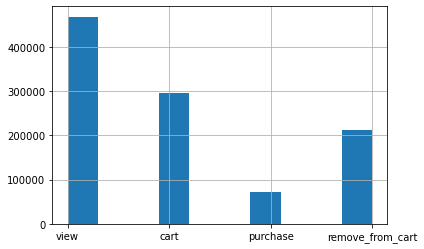

In [39]:
data_sorted.event_type.hist()

# 6. session_data 

In [40]:
grouped = data_sorted.groupby(['user_id', 'user_session', 'funnel_number'])
session_data = pd.DataFrame()

In [41]:
session_data['user_id'] = grouped['user_id'].first()
session_data['user_session'] = grouped['user_session'].first()
session_data['funnel_number'] = grouped['funnel_number'].first()
session_data['index_in_funnel'] = grouped['index_in_funnel'].apply(list)

**column e**

In [42]:
session_data['total_events'] = data_sorted.groupby(['user_id', 'user_session'])['user_session'].count()

**column f**

In [43]:
session_data['seconds_between'] = data_sorted.groupby(['user_id','user_session'])['duration_to_next_event'].sum()

**column g**

In [44]:
view_sort = data_sorted[data_sorted['event_type'] == 'view']
session_data['list_of_viewed'] = view_sort.groupby(['user_id', 'user_session'])['product_id'].apply(list)

**column h**

In [45]:
cart_sort = data_sorted[data_sorted['event_type'] == 'cart']
session_data['list_of_added_to_cart'] = cart_sort.groupby(['user_id', 'user_session'])['product_id'].apply(list)

**column i**

In [46]:
purchase_sort = data_sorted[data_sorted['event_type'] == 'purchase']
session_data['list_of_purchased '] = cart_sort.groupby(['user_id', 'user_session'])['product_id'].apply(list)

In [47]:
session_data.head(8)

user_id  \
user_id  user_session                         funnel_number             
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1               1120748   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1              10079204   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1              10521214   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1              11274156   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1              11274156   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1              13117447   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1              14297993   
15400971 33bfc3f7-32a5-408d-aa1c-d8a681977aef 1              15400971   

                                                                                     user_session  \
user_id  user_session                         funnel_number                                         
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1              d0484d94-7ac1-44e8-a310-2360da11ad9d   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1              f873d16b-4efa-4e92-81be-92948aef2ff5   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1              25d2d492-d688-4baa-adf1-7296dbdd663e   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1              0c778a88-4700-4e8b-becb-3371ec28ea79   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1              7bcf0afd-33ab-49ca-bd55-9c11a817b3d2   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1              1a345ef5-9a1e-47b3-b242-2cbb6b31d573   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1              a3bcb3c1-d3a3-49e5-b99b-7428f553a59b   
15400971 33bfc3f7-32a5-408d-aa1c-d8a681977aef 1              33bfc3f7-32a5-408d-aa1c-d8a681977aef   

                                                             funnel_number  \
user_id  user_session                         funnel_number                  
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1                          1   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1                          1   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1                          1   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1                          1   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1                          1   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1                          1   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1                          1   
15400971 33bfc3f7-32a5-408d-aa1c-d8a681977aef 1                          1   

                                                                   index_in_funnel  \
user_id  user_session                         funnel_number                          
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1                                [1]   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1                       [1, 2, 3, 4]   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1                          [1, 2, 3]   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1                             [1, 2]   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1                                [3]   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1              [1, 2, 3, 4, 5, 6, 7]   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1                             [1, 2]   
15400971 33bfc3f7-32a5-408d-aa1c-d8a681977aef 1                 [1, 2, 3, 4, 5, 6]   

                                                             total_events  \
user_id  user_session                         funnel_number                 
1120748  d0484d94-7ac1-44e8-a310-2360da11ad9d 1                         1   
10079204 f873d16b-4efa-4e92-81be-92948aef2ff5 1                         4   
10521214 25d2d492-d688-4baa-adf1-7296dbdd663e 1                         3   
11274156 0c778a88-4700-4e8b-becb-3371ec28ea79 1                         2   
         7bcf0afd-33ab-49ca-bd55-9c11a817b3d2 1                         1   
13117447 1a345ef5-9a1e-47b3-b242-2cbb6b31d573 1                         7   
14297993 a3bcb3c1-d3a3-49e5-b99b-7428f553a59b 1               